# Correlations between Spread and Mortality of COVID-19 and Factors in OECD Countries
As COVID-19 became a globally pandemic, fear spreads rampantly accross the world. Much has yet to be discovered about COVID-19. This exercise serves to find correlations between the spread and mortality rate of COVID-19, and difference factors in OECD countries. Hopefully we can gain some insight as to where investments should be directed towards in order to contain/slow the spread of future epidemics.

These factors are: <br> 
**- Health** <br>
**- Income distribution** <br> 
**- GDP** <br> 
**- Labor market** <br> 
    
Beside finding correlations between COVID-19 spread and morality rates and these factors, the secondary objective is to analyze whether implementing strict lockdown policies have an impact on the spread and mortality rate of COVID-19. <br>

**Data as of April 20, 2020*
<br>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

%matplotlib inline

from sklearn import (
    linear_model, preprocessing, neural_network, pipeline, model_selection,
)

## Download and Clean Data

### COVID-19 Data
I download COVID-19 data from the European Centre for Disease Prevention and Control. The source is time series data starting from December 31, 2019 that reports new development in cases and deaths worldwide. 

According to ECDC: "Every day between 6.00 and 10.00 CET, a team of epidemiologists screens up to 500 relevant sources to collect the latest figures. The data screening is followed by ECDC’s standard epidemic intelligence process for which every single data entry is validated and documented in an ECDC database."

In [6]:
#Get COVID-19 data from ECDC
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  11981 non-null  object 
 1   day                      11981 non-null  int64  
 2   month                    11981 non-null  int64  
 3   year                     11981 non-null  int64  
 4   cases                    11981 non-null  int64  
 5   deaths                   11981 non-null  int64  
 6   geoId                    11944 non-null  object 
 7   continentExp             11981 non-null  object 
 8   countryterritoryCode     11856 non-null  object 
 9   popData2018              11890 non-null  float64
 10  countriesAndTerritories  11981 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.0+ MB


In [7]:
#Change the date to correct data type
df["dateRep"] = pd.to_datetime(df['dateRep'],dayfirst=True)

In [8]:
#Specify countries of interest (OECD countries)
C = "countriesAndTerritories"

df[C] = df[C].map(lambda x:x.replace("_"," "))
oecd = pd.Series(["Australia","Austria","Belgium","Canada","Chile","Czech Republic","Denmark","Estonia","Finland",
                 "France","Germany","Greece","Hungary","Iceland","Ireland","Israel","Italy","Japan","South Korea",
                 "Latvia","Lithuania","Luxembourg","Mexico","Netherlands","New Zealand","Norway","Poland","Portugal",
                 "Slovak Republic","Slovenia","Spain","Sweden","Switzerland","Turkey","United Kingdom","United States"])

countries = df[C]
oecddf = df[countries.isin(oecd)]

In [9]:
#Find and investigate OECD countries not in ECDC data
np.setdiff1d(oecd,oecddf[C].unique())
#output: ['Czech_Republic', 'Slovak_Republic', 'United_States']

df[countries.str.contains("Czech")][C].unique()
#output: 'Czechia'

df[countries.str.contains("Slovak")][C].unique()
#output: 'Slovakia'

df[countries.str.contains("United States")][C].unique()
#output: ['United_States_of_America', 'United_States_Virgin_Islands']

array(['United States of America', 'United States Virgin Islands'],
      dtype=object)

In [10]:
#Specify COVID-19 dataframe with complete OECD countries
complete_oecd = oecd.tolist()
complete_oecd.remove("Czech Republic")
complete_oecd.remove("Slovak Republic")
complete_oecd.remove("United States")
complete_oecd.append("Czechia")
complete_oecd.append("Slovakia")
complete_oecd.append("United States of America")
complete_oecddf = df[countries.isin(complete_oecd)]

In [11]:
#Add spread rate, mortality rate and cumulative cases and deaths
complete_oecddf = complete_oecddf.sort_values([C,"dateRep"])
complete_oecddf["cumDeaths"] = complete_oecddf.groupby([C])["deaths"].cumsum()
complete_oecddf["cumCases"] = complete_oecddf.groupby([C])["cases"].cumsum()
complete_oecddf["spreadRate"] = complete_oecddf.groupby([C])["cumCases"].pct_change()
complete_oecddf["mortalityRate"] = complete_oecddf["cumDeaths"]/complete_oecddf["cumCases"]
complete_oecddf = complete_oecddf.replace([np.inf, -np.inf], np.nan)
complete_oecddf.reset_index()
complete_oecddf.tail()

,dateRep,day,month,year,cases,deaths,geoId,continentExp,countryterritoryCode,popData2018,countriesAndTerritories,cumDeaths,cumCases,spreadRate,mortalityRate
11553,2020-04-16,16,4,2020,30148,4928,US,America,USA,327167434.0,United States of America,30985,639664,0.049462,0.048439
11552,2020-04-17,17,4,2020,31667,2299,US,America,USA,327167434.0,United States of America,33284,671331,0.049506,0.049579
11551,2020-04-18,18,4,2020,30833,3770,US,America,USA,327167434.0,United States of America,37054,702164,0.045928,0.052771
11550,2020-04-19,19,4,2020,32922,1856,US,America,USA,327167434.0,United States of America,38910,735086,0.046886,0.052933
11549,2020-04-20,20,4,2020,24601,1772,US,America,USA,327167434.0,United States of America,40682,759687,0.033467,0.053551


Text(0, 0.5, 'Three Day Rolling Average of New Cases')

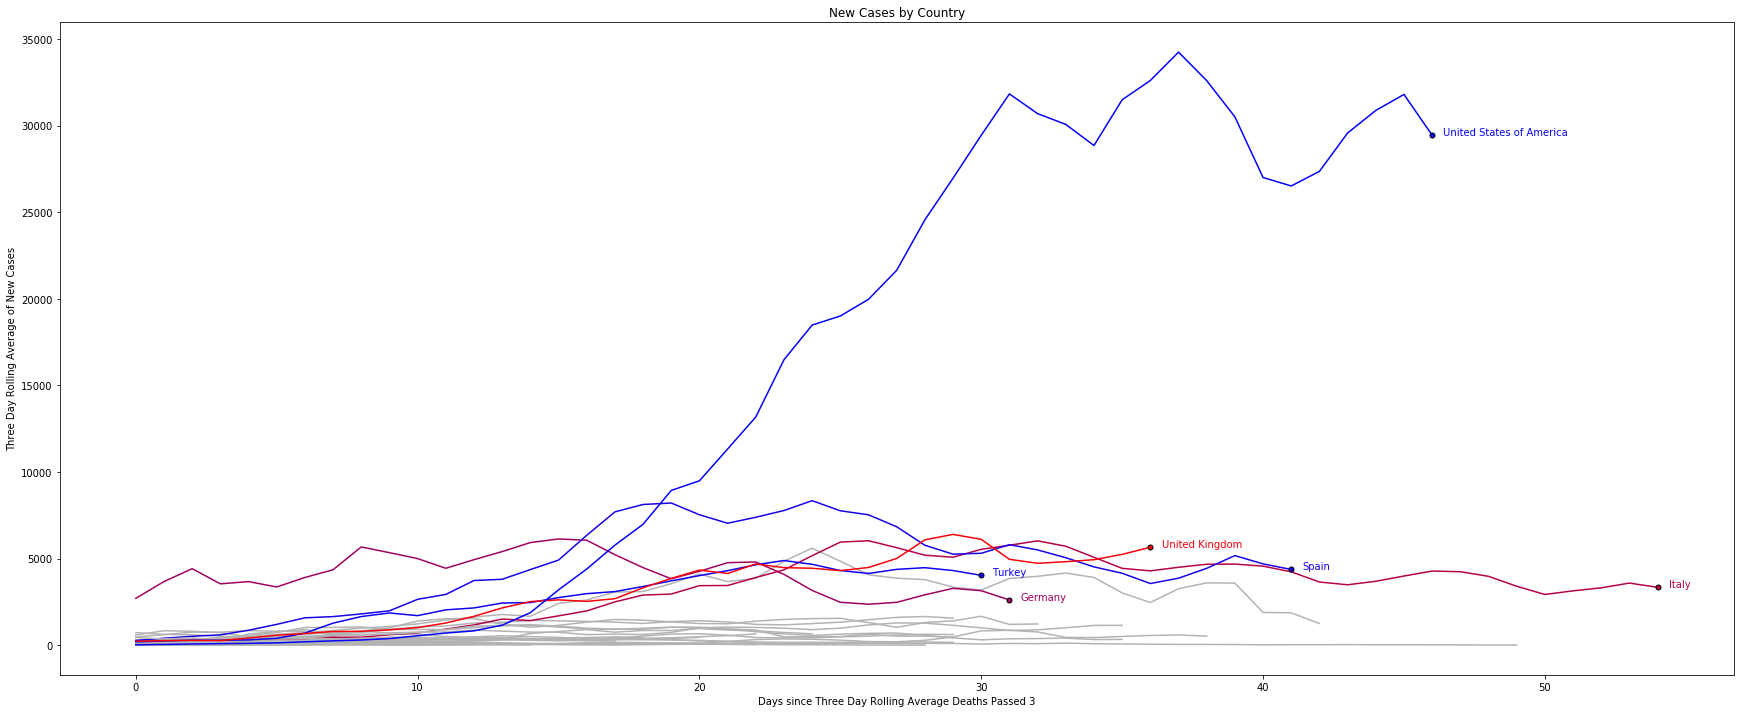

In [12]:
#Show trend of new cases
complete_oecddf["rollingDeaths"] = complete_oecddf.groupby([C])["deaths"].transform(lambda x: x.rolling(3).mean())
complete_oecddf["rollingCases"] = complete_oecddf.groupby([C])["cases"].transform(lambda x: x.rolling(3).mean())
death_past_three = complete_oecddf[complete_oecddf.rollingDeaths >= 3].groupby([C]).first()["dateRep"]

case_df = pd.merge(complete_oecddf,death_past_three, how = "left", on = C)
case_df["daysPastThreeDeaths"] = (case_df["dateRep_x"] - case_df["dateRep_y"]).dt.days
case_df = case_df[case_df.daysPastThreeDeaths >= 0]

fig, ax = plt.subplots(figsize=(30,12))

num_country = len(complete_oecddf[C].unique().tolist())
grey = (0.7,0.7,0.7)
colors = pd.Series([(0,0,1)])

for i in range(num_country):
    j = (1/3 - 2/3*np.cos(2*i*np.pi/3) - 2/3*np.cos(4*i*np.pi/3))/70
    colors = colors.append(pd.Series([(0.5-i*j,0,0.5+i*j)]))
cmap = dict(zip(complete_oecddf[C].unique(), colors))

current_cases = 2000

for country, df in case_df.reset_index().groupby(C):
    latest_day = df["daysPastThreeDeaths"].tail(1)
    latest_cases = df["rollingCases"].tail(1)
    
    if latest_cases.tolist()[0] >= current_cases:    
        df.plot(x="daysPastThreeDeaths",y="rollingCases", ax=ax,legend=False, color=cmap[country])
        ax.plot(latest_day,latest_cases,'o', markeredgecolor="black", markersize=5, color=cmap[country], zorder=10)

        x = latest_day + 0.4
        y = latest_cases + 1
        ax.annotate(country,(x,y),color=cmap[country])  
    else:
        df.plot(x="daysPastThreeDeaths",y="rollingCases", ax=ax,legend=False, color=grey)

ax.set_title("New Cases by Country")
ax.set_xlabel("Days since Three Day Rolling Average Deaths Passed 3")
ax.set_ylabel("Three Day Rolling Average of New Cases")

We can see most countries have kept their three day frolling average of new cases under 2,000 with only the United States of America soaring high at more than 30,000 three day rolling average cases. 

Text(0, 0.5, 'Three Day Rolling Average of New Cases')

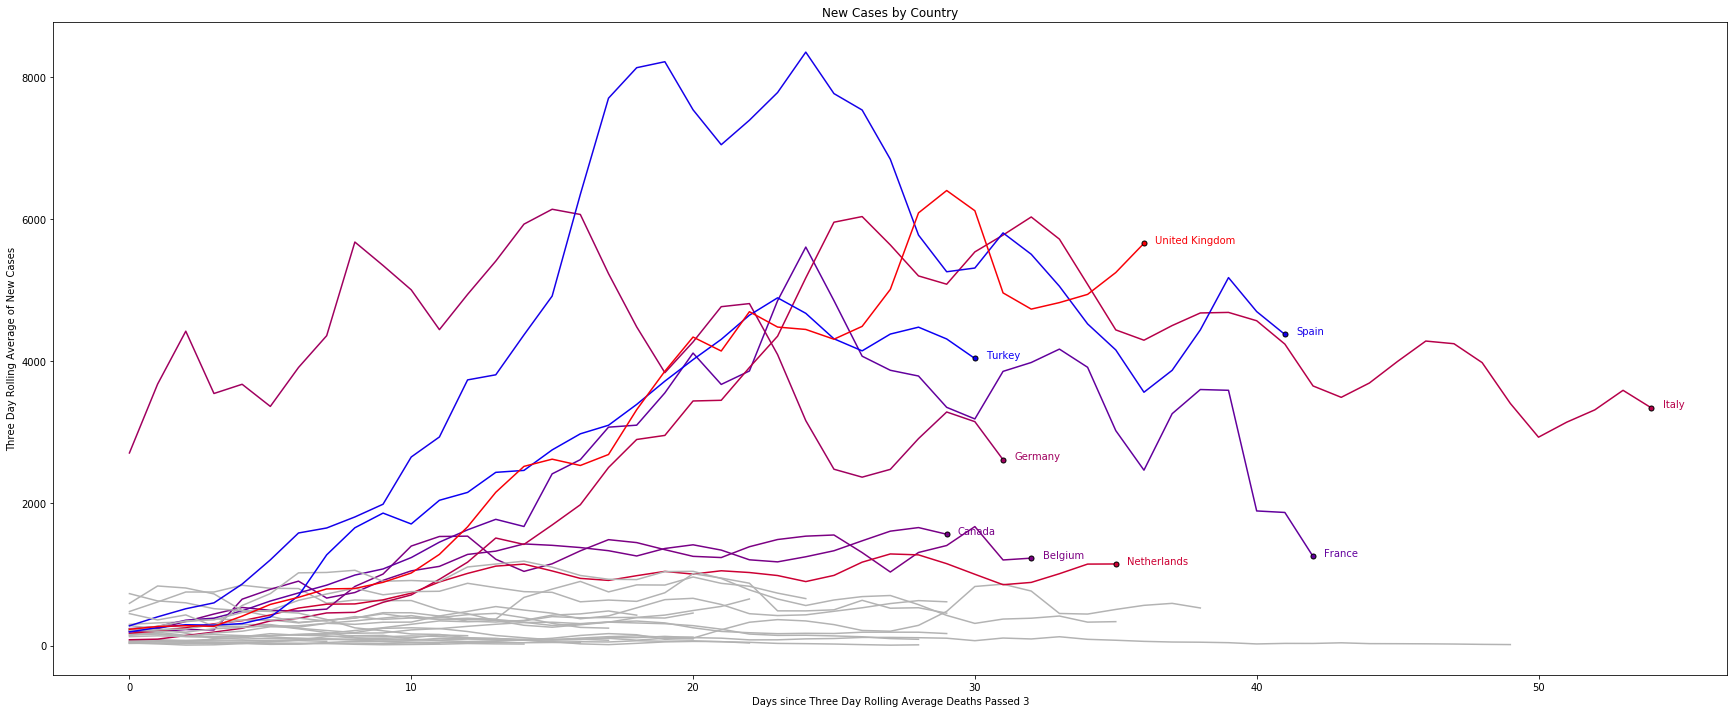

In [13]:
#Gain a better look by excluding the outlier (USA)
fig, ax = plt.subplots(figsize=(30,12))

no_us_df = case_df[~case_df[C].isin(["United States of America"])]
current_cases = 1000

for country, df in no_us_df.reset_index().groupby(C):
    latest_day = df["daysPastThreeDeaths"].tail(1)
    latest_cases = df["rollingCases"].tail(1)
        
    if latest_cases.tolist()[0] >= current_cases:
        df.plot(x="daysPastThreeDeaths",y="rollingCases", ax=ax,legend=False, color=cmap[country])
        ax.plot(latest_day,latest_cases,'o', markeredgecolor="black", markersize=5, color=cmap[country], zorder=10)
        
        x = latest_day + 0.4
        y = latest_cases + 1
        ax.annotate(country,(x,y),color=cmap[country]) 
    else:
        df.plot(x="daysPastThreeDeaths",y="rollingCases", ax=ax,legend=False, color=grey)
        
ax.set_title("New Cases by Country")
ax.set_xlabel("Days since Three Day Rolling Average Deaths Passed 3")
ax.set_ylabel("Three Day Rolling Average of New Cases")

Most countries have kept their three day rolling average of new cases under 1,000 with only a handful of OECD countries with excess of 1,000 new cases a day. It is noteworthy that Italy, Spain, France, and Germany have seen declining new cases whereas Canada, the Netherlands, and the United Kingdom are still seeing an increasing number of daily cases. 

In [14]:
#Examine deaths over time
def plot_death(in_df,cutoff):
    #This function takes in a dataframe and cutoff and
    #plots the moving 3 day average deaths and names
    #the countries with deaths above the cutoff
    
    fig, ax = plt.subplots(figsize=(30,12))
    current_deaths = cutoff
    
    for country, df in in_df.reset_index().groupby(C):
        latest_day = df["daysPastThreeDeaths"].tail(1)
        latest_deaths = df["rollingDeaths"].tail(1)

        if latest_deaths.tolist()[0] >= current_deaths:
            df.plot(x="daysPastThreeDeaths",y="rollingDeaths", ax=ax,legend=False, color=cmap[country])
            ax.plot(latest_day,latest_deaths,'o', markeredgecolor="black", markersize=5, color=cmap[country], zorder=10)

            x = latest_day + 0.4
            y = latest_deaths + 1    
            ax.annotate(f"{country}\nMortality Rate:{df['mortalityRate'].tail(1).values[0].round(4)}",(x,y),color=cmap[country])
        else:
            df.plot(x="daysPastThreeDeaths",y="rollingDeaths", ax=ax,legend=False, color=grey)

    ax.set_title("New Deaths by Country")
    ax.set_xlabel("Days since Three Day Rolling Average Deaths Passed 3")
    ax.set_ylabel("Three Day Rolling Average of Deaths")

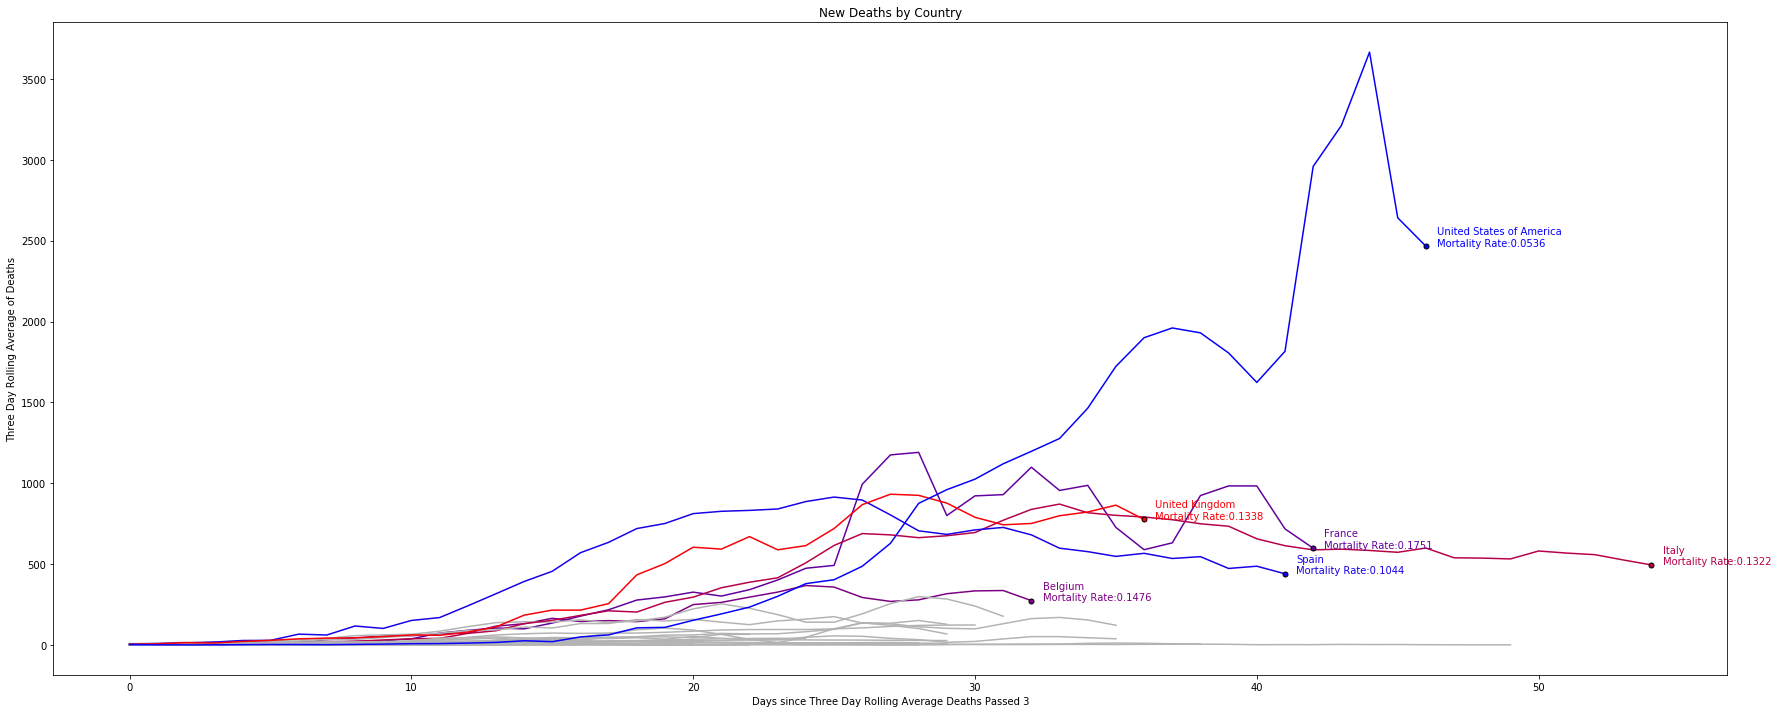

In [15]:
plot_death(case_df,200)

Very few OECD countries have above an 3 day average of 200 daily deaths with USA leading the pack at more than 2,500 average daily deaths during the past 3 day.

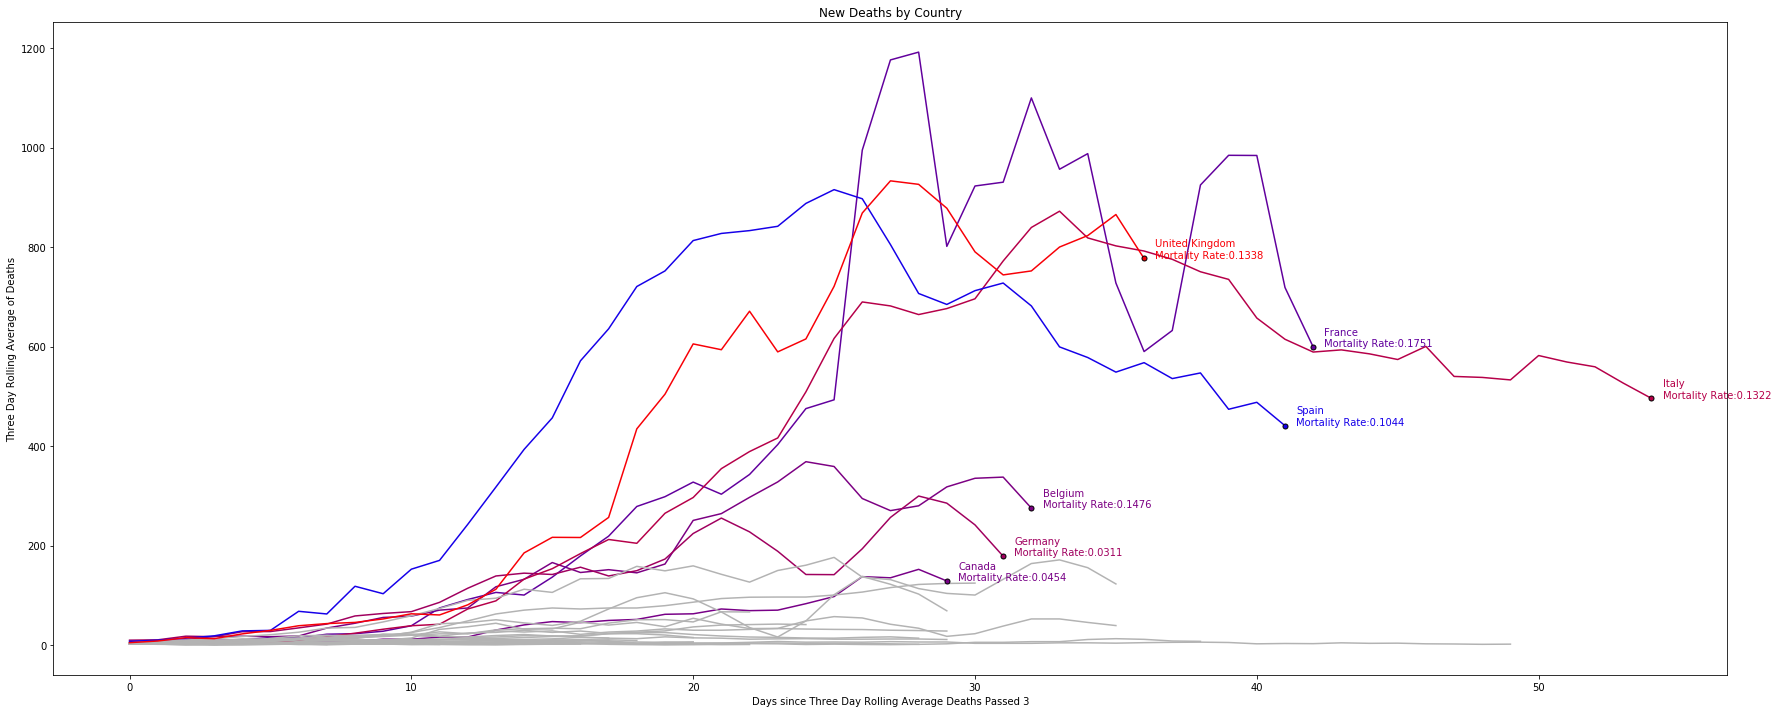

In [16]:
plot_death(no_us_df,125)

We saw Canada, the Netherlands and UK have increasing new cases and fortunately they are seeing decreasing deaths. It seems as though average deaths has past its peak and started to fall. What is interesting here is the vast difference between mortality rates, France has a mortality rate of 17.5% whereas their neighbor, Germany, only has a mortality rate of 3.1%.

### OECD Data
I download OECD data from OECD.Stat. OECD compiles data on key indicators on OECD countries. I will use the most recent data for each country.

There are a couple of indicators that I am interested in looking at:

**- Health**: Health expenditure per capita (USD), life expentancy (years), deaths by illness (person), tabacco consumption (average cigarettes per day), smoking population (% of total population) alcohol consumption per capita (litres), health workers (person), hospital beds<br>
**- Income distribution**: Gini coefficient  <br> 
**- GDP (Expenditure approach)**: Quarterly growth rate (%), Annual GDP (Millions of USD)<br> 
**- Labor market**: Minimum wage per hour(USD), Annual hours worked per worker (hours) <br> 

Data is compiled annually and reflect numbers aggregated on an annual basis. Furthermore, the most recent data for most factors will be 2017 or 2018.

In [17]:
#Define a function to download and clean data
def clean_data(url,new_name,filter1=[],filter2=[],filter3=[],masterdf=pd.DataFrame(),group="Country"):
    #This function takes in an URL, new variable name, filters
    #and download the data. Furthermore, it filters and group
    #the data and finally merges the data onto the master
    #dataframe.
    
    url = url
    df = pd.read_csv(url)
    df = df[df["Country"].isin(oecd)]
        
    if filter1 != [] and filter2 != [] and filter3 != []:
        df = df[df[filter1[0]].isin([filter1[1]])]
        df = df[df[filter2[0]].isin([filter2[1]])]
        df = df[df[filter3[0]].isin([filter3[1]])].groupby(group).last().reset_index()
    elif filter1 != [] and filter2 != []:
        df = df[df[filter1[0]].isin([filter1[1]])]
        df = df[df[filter2[0]].isin([filter2[1]])].groupby(group).last().reset_index()
    elif filter1 != []:
        df = df[df[filter1[0]].isin([filter1[1]])].groupby(group).last().reset_index()
    else:
        df = df.groupby(group).last().reset_index()
        
    df = df.filter(["Country","Value"]).rename(columns={"Value":f"{new_name}"})
    
    if masterdf.empty:
        return df
    else:
        masterdf = pd.merge(masterdf,df, how = "left", on = "Country")
        return masterdf

**Health**

In [18]:
#Download and clean alcohol consumtion data
healthdf = clean_data("Data/alcohol.csv","Alcohol liters per capita")

#Download and clean deaths data
healthdf = clean_data("Data/deaths.csv","Deaths by illness",
                      ["Variable","All causes of death"],masterdf = healthdf)

#Download and clean health expenditure data
healthdf = clean_data("Data/healthexp.csv","Health expenditure per capita",
                      ["Function","Current expenditure on health (all functions)"],["Measure",
                      "Per capita, current prices, current PPPs"],["Financing scheme","All financing schemes"],masterdf = healthdf)

#Download and clean health workers data
healthdf = clean_data("Data/healthworkers.csv","Health workers",["Measure",
                      "Number of persons (head counts)"],masterdf = healthdf)

#Download and clean hospital beds data
healthdf = clean_data("Data/hospital beds.csv","Hospital beds",
                      ["Variable","Total hospital beds"],["Measure","Number"],masterdf = healthdf)

#Download and clean life expectancy data
healthdf = clean_data("Data/lifeexpect.csv","Life expectancy",
                      ["Variable","Total population at birth"],["Measure","Years"],masterdf = healthdf)

#Download and clean tabacco consumption data, there are data missing so I researched and mannually input the values.
healthdf = clean_data("Data/tabacco.csv","Smoker smoke per day",
                      ["Measure","Cigarettes per smoker per day"],masterdf = healthdf)
healthdf = clean_data("Data/tabacco.csv","Smoking population percent",
                      ["Measure","% of population aged 15+ who are daily smokers"],masterdf = healthdf)

healthdf.isna().sum()

Country                          0
Alcohol liters per capita        0
Deaths by illness                0
Health expenditure per capita    0
Health workers                   0
Hospital beds                    0
Life expectancy                  0
Smoker smoke per day             4
Smoking population percent       0
dtype: int64

In [19]:
#There are four values missing for smoker_smoke_per_day so I researched and will input the numbers manually.
#The values are missing for Iceland, Lithuania, Portugal, and Sweden. I will use 2012 data from the 
#Institute of Health Metrics and Evaluation

def change_data(by_var, indexs, values, column, df):
    #This function will change the value in the column and index 
    #of the data frame passed in to the new values
    var = column
    change = indexs
    change_to = values
    
    for i in zip(change,change_to):
        ind = df.loc[df[by_var]==i[0]].index[0]
        df.at[ind,var] = i[1]
        
change_data("Country", ["Iceland", "Lithuania", "Portugal", "Sweden"], [22,13.4,14.7,17.5],
            "Smoker smoke per day", healthdf)
healthdf.head()

,Country,Alcohol liters per capita,Deaths by illness,Health expenditure per capita,Health workers,Hospital beds,Life expectancy,Smoker smoke per day,Smoking population percent
0,Australia,9.4,158504,5005.316,1674564.40,92826.0,82.6,13.4,12.4
1,Austria,11.8,83270,5395.106,459070.00,64805.0,81.7,15.6,24.3
2,Belgium,10.4,108097,4943.537,618400.00,64248.0,81.6,15.9,18.9
3,Canada,8.2,264333,4974.330,1856910.00,92466.0,82.0,14.4,12.0
4,Chile,7.9,104000,2181.726,445838.81,38853.0,80.2,12.7,24.5


**Income Distribution**

In [38]:
#Download and clean gini coeifficient data
iddf = clean_data("Data/gini.csv","Gini",["Measure","Gini (disposable income, post taxes and transfers)"],
                  ["Age group","Total population"],["METHODO","METH2012"])
iddf.head()

D:\Python\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Country,Gini
0,Australia,0.325
1,Austria,0.275
2,Belgium,0.263
3,Canada,0.310
4,Chile,0.460
5,Czech Republic,0.249
6,Denmark,0.261
7,Estonia,0.309
8,Finland,0.266
9,France,0.292


**GDP**

In [21]:
#Download and clean GDP growth data
gdpdf = clean_data("Data/gdp growth.csv","Quarterly gdp growth percent",["Measure","Growth rate compared to previous quarter, seasonally adjusted"],
                  ["Subject","Gross domestic product - expenditure approach"])

#Download and clean GDP data
gdpdf = clean_data("Data/gdp.csv","Gdp MM",["Measure","Current prices, current exchange rates"],
                  ["Transaction","Gross domestic product (expenditure approach)"],masterdf = gdpdf)
gdpdf.head()

,Country,Quarterly gdp growth percent,Gdp MM
0,Australia,0.526511,1.454893e+06
1,Austria,0.225426,4.461351e+05
2,Belgium,0.401346,5.302267e+05
3,Canada,0.085720,1.736328e+06
4,Chile,-4.129816,2.982311e+05


**Labor Market**

In [22]:
#Download and minimum wage data
labordf = clean_data("Data/minimum wage.csv","Minimum hourly wage",["Series","In 2018 constant prices at 2018 USD PPPs"],
                  ["Pay period","Hourly"])

#Download and clean hours worked data
labordf = clean_data("Data/hours worked.csv","Annual hours per worker",["Employment status","Total employment"],masterdf = labordf)

#Download and clean employment rate data
labordf = clean_data("Data/employment rate.csv","Employment rate",["Subject","Employment rate, Aged 15-64, All persons"],masterdf = labordf)

labordf.head()

,Country,Minimum hourly wage,Annual hours per worker,Employment rate
0,Australia,12.14,1665.04,74.41727
1,Belgium,10.38,1545.00,65.18040
2,Canada,9.52,1708.00,73.23333
3,Chile,3.12,1941.00,62.64703
4,Czech Republic,5.17,1792.00,75.09595


**Aggregate Data**

In [23]:
#Aggregate OECD data and standardize country names
agg_oecd_df = pd.merge(healthdf,iddf, how = "left", on = "Country")
agg_oecd_df = pd.merge(agg_oecd_df,gdpdf, how = "left", on = "Country")
agg_oecd_df = pd.merge(agg_oecd_df,labordf, how = "left", on = "Country")
    
change_data("Country", ["Czech Republic", "Slovak Republic", "United States"], ["Czechia", "Slovakia", "United States of America"],
            "Country", agg_oecd_df)

agg_oecd_df.isna().sum()

Country                          0
Alcohol liters per capita        0
Deaths by illness                0
Health expenditure per capita    0
Health workers                   0
Hospital beds                    0
Life expectancy                  0
Smoker smoke per day             0
Smoking population percent       0
Gini                             0
Quarterly gdp growth percent     0
Gdp MM                           0
Minimum hourly wage              8
Annual hours per worker          8
Employment rate                  8
dtype: int64

Since there are many missing values for minimum wage, annual hours worked per worker and employment rate we will drop those factors from our analysis.

In [24]:
#Add in normalized variables and drop variables not used
complete_oecddf = complete_oecddf.rename(columns={C:"Country","spreadRate":"Spread rate","mortalityRate":"Mortality rate","popData2018":"Population"})
pop = complete_oecddf.groupby("Country")["Population"].mean()
agg_oecd_df = pd.merge(agg_oecd_df,pop, how = "left", on = "Country")

agg_oecd_df["Deaths by illness per 100000"] = agg_oecd_df["Deaths by illness"]/agg_oecd_df["Population"]*100000
agg_oecd_df["Health workers per 100000"] = agg_oecd_df["Health workers"]/agg_oecd_df["Population"]*100000
agg_oecd_df["Hospital beds per 100000"] = agg_oecd_df["Hospital beds"]/agg_oecd_df["Population"]*100000
agg_oecd_df["GDP per capita"] = agg_oecd_df["Gdp MM"]/agg_oecd_df["Population"]*1000000
agg_oecd_df["Average cigarettes per day"] = agg_oecd_df["Smoker smoke per day"]*agg_oecd_df["Smoking population percent"]/100

agg_oecd_df = agg_oecd_df.drop(["Smoker smoke per day","Smoking population percent", "Minimum hourly wage",
                                "Annual hours per worker", "Employment rate"],axis=1)

In [25]:
#Aggregate the COVID-19 data
avg_spread = complete_oecddf.groupby("Country")["Spread rate"].mean().round(4)
latest_mort = complete_oecddf.groupby("Country")["Mortality rate"].last()

aggdf = pd.merge(agg_oecd_df,avg_spread, how = "left", on = "Country")
aggdf = pd.merge(aggdf,latest_mort, how = "left", on = "Country")

aggdf.head()

,Country,Alcohol liters per capita,Deaths by illness,Health expenditure per capita,Health workers,Hospital beds,Life expectancy,Gini,Quarterly gdp growth percent,Gdp MM,Population,Deaths by illness per 100000,Health workers per 100000,Hospital beds per 100000,GDP per capita,Average cigarettes per day,Spread rate,Mortality rate
0,Australia,9.4,158504,5005.316,1674564.40,92826.0,82.6,0.325,0.526511,1.454893e+06,24992369.0,634.209586,6700.302800,371.417371,58213.475245,1.6616,0.1305,0.010587
1,Austria,11.8,83270,5395.106,459070.00,64805.0,81.7,0.275,0.225426,4.461351e+05,8847037.0,941.219077,5188.968917,732.505131,50427.633817,3.7908,0.1988,0.030727
2,Belgium,10.4,108097,4943.537,618400.00,64248.0,81.6,0.263,0.401346,5.302267e+05,11422068.0,946.387292,5414.080883,562.490085,46421.250110,3.0051,0.1872,0.147626
3,Canada,8.2,264333,4974.330,1856910.00,92466.0,82.0,0.310,0.085720,1.736328e+06,37058856.0,713.278899,5010.705133,249.511210,46853.258846,1.7280,0.1408,0.045432
4,Chile,7.9,104000,2181.726,445838.81,38853.0,80.2,0.460,-4.129816,2.982311e+05,18729160.0,555.283846,2380.452781,207.446570,15923.358736,3.1115,0.2513,0.013184


## Analysis

From our prelimeray excavation we found that there are vast differences in mortality rates i.e. France has a mortality rate of 17.5% whereas its neighbor, Germany, only has a mortality rate of 3.1%. Let us take a look at the some health related statistics in France and Germany to see if the difference in mortality rate can be explained.

In [26]:
#Create a function that creates a visualization
def create_health_visual(country):
    #This function creates a spider plot of the health properties of the country
    
    countries_of_interest = country
    
    #normalize the variables so that it ranges in [0,100]
    healthstat_df = aggdf.filter(["Country","Health workers per 100000","Hospital beds per 100000",
                                  "Health expenditure per capita","Life expectancy"])
    ind = healthstat_df.Country[healthstat_df.Country == country].index[0]
    healthstat_df = healthstat_df.drop(["Country"],axis=1)
    normalized_df=(healthstat_df-healthstat_df.min())/(healthstat_df.max()-healthstat_df.min())*100

    N = len(list(normalized_df)[:])
    values=normalized_df.loc[ind].values.flatten().tolist()
    values += values[:1]

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], normalized_df, color='grey', size=8)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.annotate(country,(angles[-3]+5.1,values[-3]))

D:\Python\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


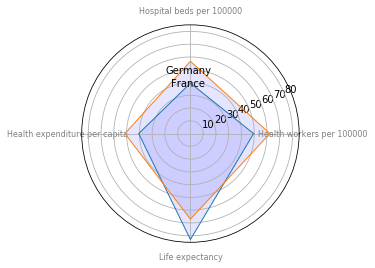

In [27]:
create_health_visual("France")
create_health_visual("Germany")

We see that even though Germany has lower life expectancy than France, it is clear that Germany has stronger health infrasture. Germany has more hospital beds, more health workers, and a larger health expenditure than France, this can help explain why Germany's COVID-19 mortality rate is significantly lower than France's

### Regression

First, I want to regress spread rate and mortality rate on the health factors of the country. Due to multicollinearity issues, namely, the correlation between hospital beds, hospital workers and health expenditure, I will only use health expenditure per capita as the representitive variable of the health care system.

In [28]:
#Regress spread rate on health factors
y = aggdf["Spread rate"]
X = aggdf.filter(["Health expenditure per capita","Life expectancy","Deaths by illness per 100000",
                  "Alcohol liters per capita","Average cigarettes per day"])

health_regression_model = linear_model.LinearRegression()
health_regression_model.fit(X, y)

#Test for significance
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            Spread rate   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     4.399
Date:                Mon, 20 Apr 2020   Prob (F-statistic):            0.00421
Time:                        16:13:56   Log-Likelihood:                 52.818
No. Observations:                  35   AIC:                            -93.64
Df Residuals:                      29   BIC:                            -84.30
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Interestingly it seems that the significant variables at 5% significance level are life expectancy, deaths by illness, and tabacco consumption. I will rerun the regression with just these three variables.

In [29]:
#Regress spread rate on significant factors
y = aggdf["Spread rate"]
X = aggdf.filter(["Life expectancy","Deaths by illness per 100000","Average cigarettes per day"])

health_regression_model = linear_model.LinearRegression()
health_regression_model.fit(X, y)

beta_0 = health_regression_model.intercept_
beta_1 = health_regression_model.coef_[0]
beta_2 = health_regression_model.coef_[1]
beta_3 = health_regression_model.coef_[2]

print(f"""Regression model: Spread rate = {beta_0:.4f} + {beta_1:.4f} * life expectancy + {beta_2:.4f} * death by illness + {beta_3:.5f} * tabacco consumption""")

Regression model: Spread rate = 1.1209 + -0.0104 * life expectancy + 
                                      -0.0002 * death by illness + 0.03640 * tabacco consumption


In [30]:
#Test for significance
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            Spread rate   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     7.431
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           0.000690
Time:                        16:13:56   Log-Likelihood:                 52.422
No. Observations:                  35   AIC:                            -96.84
Df Residuals:                      31   BIC:                            -90.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

There is negative correlation between life expectancy and spread rate of COVID-19, and positive correlation between tabacco consumption and the spread rate. These two results make sense, however what is interesting is that there is a significant negative correlation between deaths by illness and the spread rate of COVID-19. It is very counter intuitive that there is a correlation between more annual deaths and a slower COVID-19 spread rate.

In [31]:
#Regress mortality rate on health factors
y = aggdf["Mortality rate"]
X = aggdf.filter(["Health expenditure per capita","Life expectancy","Deaths by illness per 100000",
                  "Alcohol liters per capita","Average cigarettes per day"])

health_regression_model = linear_model.LinearRegression()
health_regression_model.fit(X, y)

#Test for significance
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality rate   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.101
Method:                 Least Squares   F-statistic:                    0.3742
Date:                Mon, 20 Apr 2020   Prob (F-statistic):              0.862
Time:                        16:13:56   Log-Likelihood:                 59.954
No. Observations:                  35   AIC:                            -107.9
Df Residuals:                      29   BIC:                            -98.58
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

The regression model is a very poor fit with a no significant variables, the independent variables cannot explain the mortality rate.

The final regression model I want to test is regressing spread rate on income and GDP factors. 

In [32]:
#Regress spread rate on income and GDP factors
y = aggdf["Spread rate"]
X = aggdf.filter(["Gini","Quarterly gdp growth percent"])

health_regression_model = linear_model.LinearRegression()
health_regression_model.fit(X, y)

#Test for significance
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            Spread rate   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     3.091
Date:                Mon, 20 Apr 2020   Prob (F-statistic):             0.0592
Time:                        16:13:56   Log-Likelihood:                 46.032
No. Observations:                  35   AIC:                            -86.06
Df Residuals:                      32   BIC:                            -81.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Again interesting results, both the gini coefficient and quarterly gdp growth seems to be significant variables (at 5% significance level). Both are positive coefficients, increases in the gini coefficient (more inequality) and quarterly GDP growth, increases COVID-19 spread rate in my model. The linear regression model is: 

$$
Spread Rate = 0.0535 + 0.4782*Gini + 0.0202* Quarterly GDP Growth
$$
<br>

At first it may seem counter intuitive that GDP growth is positively correlated with spread rate, but upon further consideration, faster growing countries are usually those that are less developped. Developped countries have slower growth rates, i.e Canada, Australia, US, UK.

### Neural Network

To determine the effect of implementing lockdown policies on the spread rate of COVID-19 I will use neural network to estimate the spread rate gap between countries that implemented lockdowns vs. those that did not.

**Data Prep**

In [101]:
#Create lockdown date dataframe
lockdown = {"Country":complete_oecd,
            "lockdowndate":["2020-03-23","2020-03-16","2020-03-18",np.nan,"2020-03-19",
                             "2020-03-16","2020-03-11",np.nan,"2020-03-27","2020-03-17",
                             "2020-03-20","2020-03-23","2020-03-28",np.nan,"2020-03-12",
                             "2020-04-02","2020-03-09","2020-04-07",np.nan,np.nan,"2020-03-16",
                             "2020-03-18",np.nan,"2020-03-16","2020-03-26","2020-03-12",
                             "2020-03-13","2020-03-19",np.nan,np.nan,"2020-03-14",np.nan,
                             "2020-03-17","2020-04-11","2020-03-23","2020-03-19"]}

lockdown_df = pd.DataFrame (lockdown, columns = ["Country","lockdowndate"])
lockdown_df["lockdowndate"] = pd.to_datetime(lockdown_df["lockdowndate"]) 
lockdown_df["Lockdown"] = lockdown_df["lockdowndate"].map(lambda x: pd.notnull(x))

with_lockdown_df = pd.merge(complete_oecddf,lockdown_df, how = "left", on = "Country")
with_lockdown_df["afterlockdown"] = with_lockdown_df["lockdowndate"] > with_lockdown_df["dateRep"]

In [102]:
#Aggregate the lockdown data and remove outliers
spread_after_lockdown = with_lockdown_df.groupby(["Country","afterlockdown"])["Spread rate"].mean().round(4).reset_index()
lockdown_df = pd.merge(lockdown_df,spread_after_lockdown, how = "left", on = "Country")
lockdown_df = lockdown_df[lockdown_df["Lockdown"] == lockdown_df["afterlockdown"]]
lockdown_df = lockdown_df.drop(["afterlockdown","lockdowndate"],axis=1)

agg_lockdown_df = pd.merge(lockdown_df,agg_oecd_df, how = "left", on = "Country")
agg_lockdown_df.columns = agg_lockdown_df.columns.str.replace(" ", "_")

outlier = agg_lockdown_df["Spread_rate"].mean() + 1.5 *agg_lockdown_df["Spread_rate"].std()
agg_lockdown_df = agg_lockdown_df[agg_lockdown_df["Spread_rate"] < outlier]
agg_lockdown_df.head()

,Country,Lockdown,Spread_rate,Alcohol_liters_per_capita,Deaths_by_illness,Health_expenditure_per_capita,Health_workers,Hospital_beds,Life_expectancy,Gini,Quarterly_gdp_growth_percent,Gdp_MM,Population,Deaths_by_illness_per_100000,Health_workers_per_100000,Hospital_beds_per_100000,GDP_per_capita,Average_cigarettes_per_day
0,Australia,True,0.1618,9.4,158504.0,5005.316,1674564.40,92826.0,82.6,0.325,0.526511,1.454893e+06,24992369.0,634.209586,6700.302800,371.417371,58213.475245,1.6616
1,Austria,True,0.4073,11.8,83270.0,5395.106,459070.00,64805.0,81.7,0.275,0.225426,4.461351e+05,8847037.0,941.219077,5188.968917,732.505131,50427.633817,3.7908
2,Belgium,True,0.2473,10.4,108097.0,4943.537,618400.00,64248.0,81.6,0.263,0.401346,5.302267e+05,11422068.0,946.387292,5414.080883,562.490085,46421.250110,3.0051
3,Canada,False,0.1408,8.2,264333.0,4974.330,1856910.00,92466.0,82.0,0.310,0.085720,1.736328e+06,37058856.0,713.278899,5010.705133,249.511210,46853.258846,1.7280
4,Chile,True,0.5614,7.9,104000.0,2181.726,445838.81,38853.0,80.2,0.460,-4.129816,2.982311e+05,18729160.0,555.283846,2380.452781,207.446570,15923.358736,3.1115


I will use only variables I found to have statistical significance in the linear regression model above.

In [103]:
#Transform dataframe to matrix
formula  = """Spread_rate + Lockdown ~ Deaths_by_illness_per_100000 + Life_expectancy + Average_cigarettes_per_day + 
              Gini + Quarterly_gdp_growth_percent"""
y, X = dmatrices(formula,agg_lockdown_df)
lockeddown = y[:,1]
spread_rate = y[:,2]

In [36]:
#The following functions are written by Paul Schrimpf and some values changed to fit my specifications
def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = model_selection.cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = model_selection.cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

def pickalphagridcv(g) :
    alphas = g.cv_results_["param_nn__alpha"].data
    mses = g.cv_results_["mean_test_score"]
    imin = np.argmin(mses)
    msemin = mses[imin]
    se = g.cv_results_["std_test_score"][imin]
    alpha= min([alpha for (alpha, mse) in zip(alphas, mses) if mse<msemin+se])
    return(alpha)

def plotpredictions(pl) :
    df = pd.DataFrame({"Spread rate":spread_rate,
                       "predicted":pl[1],
                       "lockeddown":lockeddown})
    sns.pairplot(df, vars=["Spread rate","predicted"], hue="lockeddown")
    plt.title("Observed and Predicted Spread Rate")

In [112]:
#Run neural network to test fit

#Use lbfgs since it can converge faster and perform better on smaller data sets.
nnp = pipeline.Pipeline(steps=[("scaling", preprocessing.StandardScaler()),
                               ("nn", neural_network.MLPRegressor((6,), activation="logistic",
                                solver="lbfgs",max_iter=2000, early_stopping=True,
                                validation_fraction=0.3))])

nndcv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=3,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,1, 20))},
                                     return_train_score=True, refit=False).fit(X,lockeddown)

nnycv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=3,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,1, 20))},
                                     return_train_score=True, refit=False).fit(X,spread_rate)

nny = nnp
nny.set_params(nn__alpha = pickalphagridcv(nnycv))
nnd = nnp
nnd.set_params(nn__alpha = pickalphagridcv(nndcv))
pl = partial_linear(spread_rate, lockeddown, X, nny, nnd)
pl[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.357
Model:                            OLS   Adj. R-squared (uncentered):              0.335
Method:                 Least Squares   F-statistic:                              16.87
Date:                Mon, 20 Apr 2020   Prob (F-statistic):                    0.000284
Time:                        16:38:01   Log-Likelihood:                         0.93228
No. Observations:                  31   AIC:                                     0.1354
Df Residuals:                      30   BIC:                                      1.569
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2120      0.052      4.108      0.000       0.111       0.313
==============================================================================
Omnibus:                        0.198   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.906   Jarque-Bera (JB):                0.405
Skew:                          -0.050   Prob(JB):                        0.817
Kurtosis:                       2.449   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

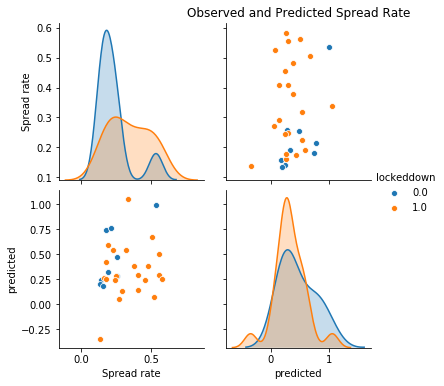

In [113]:
plotpredictions(pl)

Unfortunately due to the tiny sample size and large variation in spread rates it is very hard to come up with a good model. My model shows a statistical significance difference in spread rate between OECD countries that lockdown vs those that did not. However based on the graph above we can see that the predicted values are rather poor.

## Conclusion

There is a reliefing trend that daily deaths seem to be falling. However, we cannot relax, especially in Canada since daily new cases are on the rise. Spread rate and mortality rates vary drastically in OECD countries.

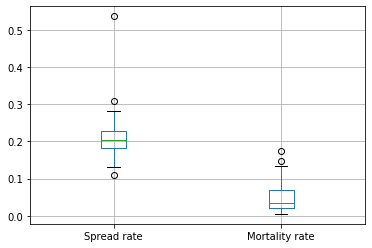

In [121]:
aggdf.boxplot(column=["Spread rate","Mortality rate"])

However we could not explain the variation in mortality rates based on factors such as health, income distribution, and GDP. What was interesting is the correlation between health, income distribution, GDP, and the spread rate of COVID-19. By regressing spread rate on life expectancy, death by illness and tabacco consumption we derived:

$$
Spread Rate = 1.1209 -0.0104 * Life Expectancy -0.0002 * Death By Illness + 0.03640 * Tabacco Consumption
$$
<br>
And regressing spread rate on the gini coefficient quarterly gdp growth I arrived at: 

$$
Spread Rate = 0.0535 + 0.4782*Gini + 0.0202* Quarterly GDP Growth
$$

Unsurprisingly there is positive correlation between tabacco consumption, gini, GDP growth, negative correlation between life expectancy and the disease spread rate. What was suprising was the negative correlation between death by illness. A possible explaination is that by having more deaths, more of the population have been exposed to different types of diseases and may have greater defense against a new disease like COVID-19.

<br>

From my neutral network model, it is inconclusive as to whether or not lockdowns have a significant impact on controlling the spread rate. One problem is that not enough time has past to see the effect of the lockdowns, another problem is that many countries issued regional lockdowns (Germany, USA, etc.) and that may have skewed the results. And time serves as the greatest restriction to this analysis, given more time as COVID-19 develops I hope to expand on my analysis.